# Amazon.com and the Rise of Useless Reviews
### How book reviews on Amazon have become less helpful

(Note: This project makes use of a random sample from a database of 8.9 million Amazon book reviews available at: http://jmcauley.ucsd.edu/data/amazon/)

Over the past decade, Amazon has come to dominate the online marketplace. In fact, in 2016 Amazon accounted for 43% of online purchases in 2016, and that percentage is only expected to increase over time (according to [BusinessInsider.com](http://www.businessinsider.com/amazon-accounts-for-43-of-us-online-retail-sales-2017-2) and [Statista.com](https://www.statista.com/statistics/788109/amazon-retail-market-share-usa/). In 2017, 64% of U.S. households had an Amazon Prime membership ([Forbes.com](https://www.forbes.com/sites/shephyken/2017/06/17/sixty-four-percent-of-u-s-households-have-amazon-prime/). As anyone who has shopped online has experienced, product reviews are a major benefit of online shopping, empowering consumers to leverage unprecedented amounts of information to make purchasing decisions. And as Amazon has grown, so has the number of product reviews it has available.

In [1]:
# Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datetime
import string
import random
import warnings

from scipy import stats
from matplotlib import colors


#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import seaborn as sns

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/regulus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load review data into csv
filename = './data/reviews_w_length.csv'
reviews_df = pd.read_csv(filename, index_col=0)

In [3]:
# Reformat data to datetime from unix format.
reviews_df['reviewTime'] = pd.to_datetime(reviews_df['unixReviewTime'], unit='s')

In [4]:
reviews_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewLength
0,000100039X,3.0,5.0,"Eloquent and full of divine wisdom, this littl...",2002-07-10,APW96HJ7GYRJH,Del Ray Zimmerman,Simply profound...,1.026259e+09,41
1,000100039X,5.0,5.0,"If I have ever read a book that is timeless, o...",2004-07-04,A1XJOSJN6FHFO0,"Shirley Priscilla Johnson ""Author/Reviewer -...",MidWest Book Review,1.088899e+09,112
2,1055178,0.0,4.0,It is amazing how some writers can blather on ...,1998-12-13,AJODIMJX61856,Rick Hunter,Spare yet telling portraits,9.135072e+08,119
3,1473727,0.0,5.0,Again received this prior to estimated deliver...,2013-02-13,AVL5UOMC6OFR5,Paul B. King,Hard to Find Biblical Facts like this,1.360714e+09,39
4,1712772,0.0,5.0,My kiddos never get tired of hearing this stor...,2012-11-02,A1QJBN13J48RK5,JB,Super cute book,1.351814e+09,27


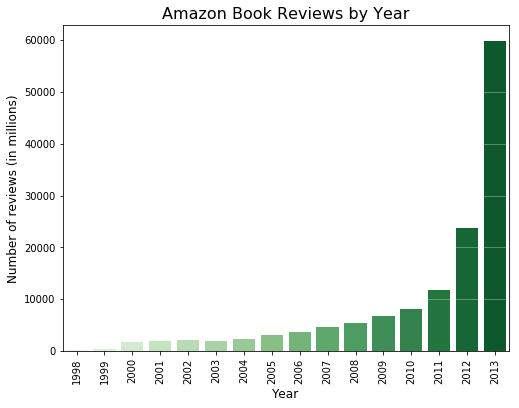

In [5]:
# Count reviews by year
reviews_by_year = reviews_df['reviewTime'].dt.year.value_counts()
# Adjust figure size of plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Use seaborn library to create a bar plot of review count by year.
sns.barplot(x=reviews_by_year.index, y=reviews_by_year.values, palette='Greens')
# Set grid lines
plt.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
# Rotate xtick labels for visibility
plt.xticks(rotation=90)
# Set x limits to cut off earliest years and 2014, which only has data through July
plt.xlim((0.5,16.5))
# Adjust yticks to account for 2% sample of data.
#yticks = [((label/0.02)/10**6)for label in plt.yticks[0]]
#ax.set_yticklabels(yticks)
# Add plot title and axis labels, show plot
plt.title('Amazon Book Reviews by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of reviews (in millions)', fontsize=12)
plt.show()

(Note: 2014 is omitted in the plot above because the sampled dataset only includes ratings and reviews through July of 2014.)

Drawing from a database of 8.9 million book reviews on Amazon, it is evident that there has been a dramatic increase in product reviews for books alone. At first glance, this would seem to be a very positive trend for consumers who read reviews before making online purchases, as there has never before been so much information available to inform a purchase. However, closer scrutiny reveals that this is not such a straightforward conclusion.  

As anyone who has shopped on Amazon has likely seen, each review on Amazon has "helpful" and "not helpful" buttons underneath it. These provide feedback to Amazon, the reviewer, and other Amazon customers that is valuable when choosing which reviews, and is really the only means of guidance in choosing reviews out of hundreds, or sometimes even thousands, to consider trustworthy.

A quick look at the average "helpful" rating of a reviews on Amazon over time reveals an interesting trend in the average number of "helpful" ratings given to reviews.

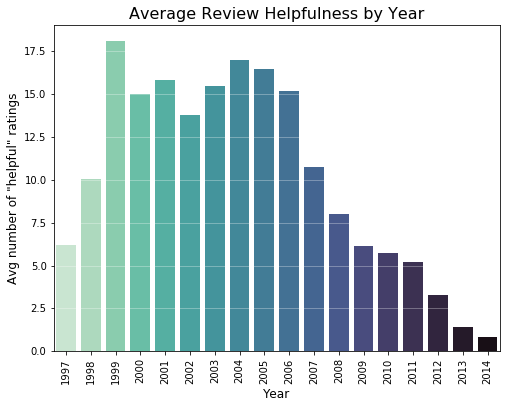

In [6]:
# Aggregate reviews by year and take the mean helpfulness of reviews in each year.
helpfulness_by_year = reviews_df['helpful'].groupby(reviews_df['reviewTime'].dt.year).mean()
#A djust figure size
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Create a barplot of average helpfulness by year.
sns.barplot(x=helpfulness_by_year.index, y=helpfulness_by_year.values, palette='mako_r')
# Set grid lines
plt.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
# Rotate xtick labels for visibility
plt.xticks(rotation=90)
# Add plot title and axis labels, show plot
plt.title('Average Review Helpfulness by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg number of "helpful" ratings', fontsize=12)
plt.show()

As can be seen in the plot above, the average "helpful" rating of reviews declined dramatically from 2006 to 2007 and has continued to decline ever since. It is apparent that, while the number of book reviews on Amazon has grown very rapidly, a much lower percentage of people consider them helpful.  

As the number of book reviews on Amazon has increased dramatically, the number that are rated helpful has not increased proportionately. Compared to the years 2000 to 2008, the years 2011 to 2014 have a much smaller percentage of reviews that have been rated helpful by even one person - even though far more reviews are posted in these years.

There are a number of possible causes for this, one of which is simply that people are not putting as much effort into writing reviews. One way to measure this is the look at the average length of reviews over time as can be seen in the chart below.


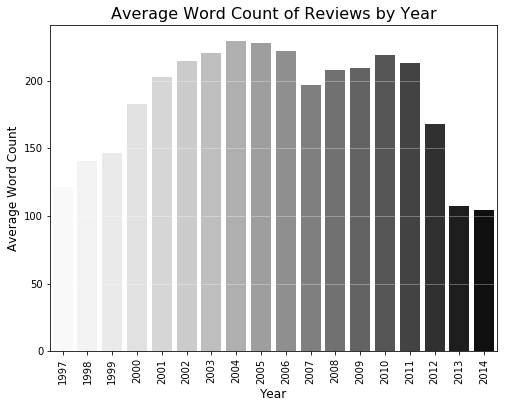

In [7]:
# Aggregate reviews by year take the mean length of reviews in each year.
review_length_by_year = reviews_df['reviewLength'].groupby(reviews_df['reviewTime'].dt.year).mean()
# Adjust figure size
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Create a barplot of the average review length each year.
sns.barplot(x=review_length_by_year.index, y=review_length_by_year.values, palette='Greys')
# Set grid lines
plt.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
# Rotate xtick labels for visibility
plt.xticks(rotation=90)
# xc, show plot
plt.title('Average Word Count of Reviews by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Word Count', fontsize=12)
plt.show()

A very large drop-off in length for the average Amazon review can be observerd starting in 2012 and becoming more drastic in 2013 and 2014. This appears to correlate with the steepest drop-offs in the helpfulness of the average review, as well as the sharpest increases in number of book reviews on Amazon.

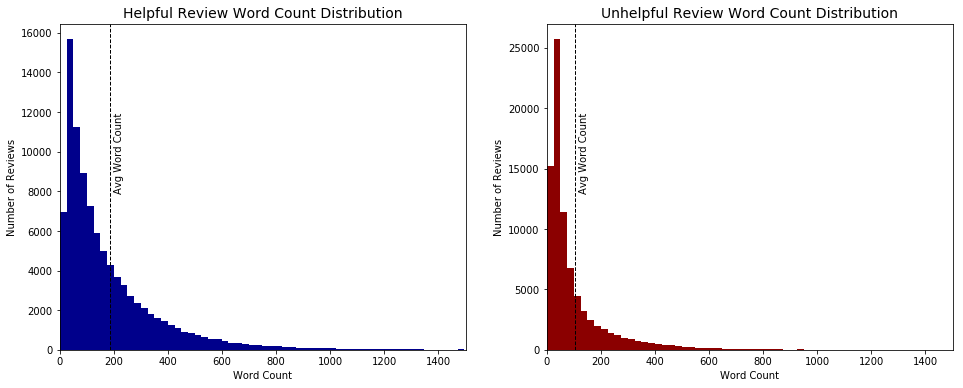

Average word count of reviews with at least 1 "helpful" rating = 185
Average word count of reviews with zero "helpful" ratings = 104


In [8]:
# Create dataframe of reviews rated helpful by at least one person.
helpful_review_length = reviews_df[reviews_df['helpful'] >= 1.0]['reviewLength']
# Create dataframe of reviews that that were not rated helpful.
unhelpful_review_length = reviews_df[reviews_df['helpful'] == 0]['reviewLength']
# Setup subplots, figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Configure first plot from helpful reviews dataframe 
ax1.hist(helpful_review_length, bins=200, color='darkblue')
# Cut off outliers by setting limit on x axis
ax1.set_xlim(xmin=0, xmax = 1500)
# Set vertical line at mean
ax1.axvline(helpful_review_length.mean(), color='k', linestyle='dashed', linewidth=1)
# Label vertical line
ax1.text(200,11600,'Avg Word Count',rotation=90)
# Add plot title and axis labels
ax1.set_title('Helpful Review Word Count Distribution', fontsize=14)
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Number of Reviews')

# Configure second plot from unhelpful reviews dataframe
ax2.hist(unhelpful_review_length, bins=200, color='darkred')
# Cut off outliers by setting limit on x axis
ax2.set_xlim(xmin=0, xmax = 1500)
# Set vertical line at mean
ax2.axvline(unhelpful_review_length.mean(), color='k', linestyle='dashed', linewidth=1)
# Label vertical line
ax2.text(120,19000,'Avg Word Count',rotation=90)
# Add plot title and axis labels, show plot
ax2.set_title('Unhelpful Review Word Count Distribution', fontsize=14)
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Number of Reviews')
plt.show()

# Print average word counts per plot below them.
print('Average word count of reviews with at least 1 "helpful" rating = %0.0f' % helpful_review_length.mean())
print('Average word count of reviews with zero "helpful" ratings = %0.0f' % unhelpful_review_length.mean())

As the charts above show, longer reviews do tend to be rated as "helpful" more often. The plot on the left shows the  distribution of word counts for reviews that have at least one helpful rating, with the average word count for these being 185. This word count is 80% higher than that of reviews that received no helpful ratings at all. The distribution of word counts for reviews with no helpful ratings can be seen in the plot on the right, which shows an average word count much lower than reviews that have been rated helpful.

Looking into this further, a sharp decline in number of reviews consisting of more than 185 words is apparent, as is a drastic increase in reviews consisting of 40 words or less. 

In 2011, more than 40% of book reviews on Amazon consisted of more than 185 words, and 11% of reviews consisted of fewer than 40 words. Within the span of 2 years, this comparison was turned on its head. In 2013, over 40% of reviews consisted of fewer than 40 words. Only 15% of reviews consisted of more than 185 words.

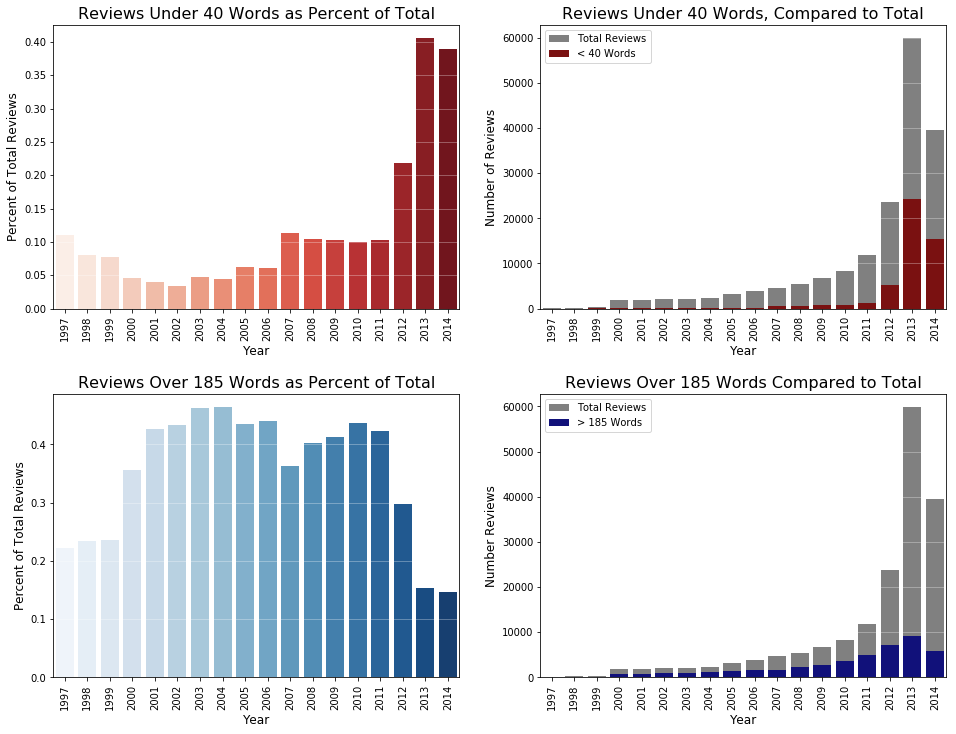

In [9]:
# Setup data to plot short review comparison, as percentage and by count comparison
short_reviews_by_year = reviews_df[reviews_df['reviewLength'] < 40]\
                    .groupby(reviews_df['reviewTime'].dt.year).size()/reviews_by_year
short_reviews_comp = reviews_df[reviews_df['reviewLength'] < 40]\
                    .groupby(reviews_df['reviewTime'].dt.year).size()

# Setup data to plot long review comparison, as percentage and by count comparison
long_reviews_by_year = reviews_df[reviews_df['reviewLength'] > 185]\
                .groupby(reviews_df['reviewTime'].dt.year).size()/reviews_by_year
long_reviews_comp = reviews_df[reviews_df['reviewLength'] > 185]\
                    .groupby(reviews_df['reviewTime'].dt.year).size()    

# Configure subplot layout and size
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(16, 12))
# Adjust spacing between subplots
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.3)

# Configure first subplot (top-left)
sns.barplot(x=short_reviews_by_year.index, y=short_reviews_by_year.values, ax=ax1, palette='Reds')
# Set grid lines
ax1.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
ax1.yaxis.grid(True)
ax1.xaxis.grid(False)
# Add plot title and axis labels
ax1.set_title('Reviews Under 40 Words as Percent of Total', fontsize=16)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Percent of Total Reviews', fontsize=12)

# Configure second subplot (top-right)
sns.barplot(x=reviews_by_year.index, y=reviews_by_year.values, ax=ax2, color='grey', label='Total Reviews')
sns.barplot(x=short_reviews_comp.index, y=short_reviews_comp.values, ax=ax2, color='darkred', label='< 40 Words')
# Set grid lines
ax2.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
ax2.yaxis.grid(True)
ax2.xaxis.grid(False)
# Add plot title and axis labels, legend
ax2.set_title('Reviews Under 40 Words, Compared to Total', fontsize=16)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Number of Reviews', fontsize=12)
ax2.legend()

# Configure third subplot (bottom-left)
sns.barplot(x=long_reviews_by_year.index, y=long_reviews_by_year.values, ax=ax3, palette='Blues')
# Set grid lines
ax3.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
ax3.yaxis.grid(True)
ax3.xaxis.grid(False)
# Add plot title and axis labels
ax3.set_title('Reviews Over 185 Words as Percent of Total', fontsize=16)
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Percent of Total Reviews', fontsize=12)

# Configure fourth subplot (bottom-right)
sns.barplot(x=reviews_by_year.index, y=reviews_by_year.values, ax=ax4, color='grey', label='Total Reviews')
sns.barplot(x=long_reviews_comp.index, y=long_reviews_comp.values, ax=ax4, color='darkblue', label='> 185 Words')
# Set grid lines
ax4.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
ax4.yaxis.grid(True)
ax4.xaxis.grid(False)
# Add plot title and axis labels, legend
ax4.set_title('Reviews Over 185 Words Compared to Total', fontsize=16)
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Number Reviews', fontsize=12)
ax4.legend()

# Rotate all axes by 90 degrees
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    
# Show plots
plt.show()


From all of the plots above, it seems evident that while Amazon reviews have become more numerous, they've also become much shorter, and are generally considered less helpful. 2012 seems to be a very pivotal year in this trend, as number of reviews under 40 words rose sharply in this year and reviews over 185 words fell. Some research yields a potential reason.

In 2012 Amazon began removing reviews that did not meet certain criteria, and it removed them in large numbers. [A New York Times article](http://blog.karenwoodward.org/2012/11/amazon-reviews-are-disappearing.html) described Amazon's policy as:
>Giving rave reviews to family members is no longer acceptable. Neither is writers’ reviewing other writers. But showering five stars on a book you admittedly have not read is fine.

The blogosphere also lit up with commentary and investigation. Some reviewers who complained about their reviews received a form letter from Amazon stating: 
>I'm sorry for any previous concerns regarding your reviews on our site. We do not allow reviews on behalf of a person or company with a financial interest in the product or a directly competing product. This includes authors, artists, publishers, manufacturers, or third-party merchants selling the product.   
<br>We have removed your reviews as they are in violation of our guidelines.  We will not be able to go into further detail about our research.  
<br>I understand that you are upset, and I regret that we have not been able to address your concerns to your satisfaction. However, we will not be able to offer any additional insight or action on this matter.  
<br></br>


Many authors posted complaints on their blogs that their book reviews were disappearing. One such author, [Joe Konrath](http://jakonrath.blogspot.com/2012/11/amazon-removes-reviews.html), complained to Amazon, stating:
>My reviews followed all of Amazon's guidelines, and had received hundreds of helpful votes. They informed customers, and they helped sell books. They represented a significant time investment on my part, and they were honest and accurate and fully disclosed my relationships with the author I reviewed if I happened to know them. And these reviews were deleted without warning or explanation.

<br></br>
An [article at Forbes.com](https://www.forbes.com/sites/suwcharmananderson/2012/11/07/amazon-tackles-review-problem-deletes-wrong-reviews/#53f12ee87f2a) chronicled many more complaints by authors and other reviewers.  

Amazon began implementing this policy in September of 2012. Looking again at the decline in average review length, viewing it by quarter instead of by year, shows that this policy affected average review length immediately and drastically.

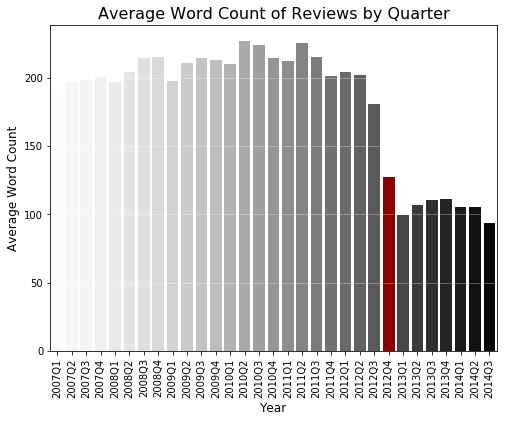

In [10]:
# Aggregate reviews by year take the mean length of reviews in each year.
review_length_by_year = reviews_df['reviewLength'].groupby(reviews_df['reviewTime'].dt.to_period('Q')).mean()
# Adjust figure size
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Create a barplot of the average review length each year.
sns.barplot(x=review_length_by_year.index[39:], y=review_length_by_year.values[39:], palette='Greys')
# Set grid lines
plt.grid(color='white', linewidth=1, fillstyle='full', alpha=0.3)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
ax.patches[23].set_color('darkred')
# Rotate xtick labels for visibility
plt.xticks(rotation=90)
# xc, show plot
plt.title('Average Word Count of Reviews by Quarter', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Word Count', fontsize=12)
plt.show()

It appears that when Amazon decided to remove reviews written by people who write as a profession, the average review length dropped immediately. Since longer reviews tend to be rated as helpful, fewer reviews were then considered helpful. The changes in policy simultaneously allowed the spamming of low-content reviews, so the number of reviews grew dramatically.

This gives us three metrics to compare for correlation - the number of reviews overall, the proportion of those that fewer than 40 words, and number of helpful ratings given per review. These will be compared on a monthly basis since 2011.

In [11]:
time_filter = reviews_df['reviewTime'].dt.year >= 2008
length_filter = reviews_df['reviewLength'] <= 40
# Count number of reviews overall per month since beginning of 2011.
M_review_count = reviews_df[time_filter]['reviewLength'].groupby(reviews_df['reviewTime'].dt.to_period('W')).count()
# Calculate proportion of reviews containing 40 words or fewer per month.
M_short_review_pct = reviews_df[time_filter & length_filter]['reviewLength'].groupby(
    reviews_df['reviewTime'].dt.to_period('W')).count()/M_review_count
# Calculate average number of helpful ratings given per review per month.
M_helpful_ratings_avg = reviews_df[time_filter]['helpful'].groupby(
    reviews_df['reviewTime'].dt.to_period('W')).mean()

In [12]:
df_compare = pd.DataFrame(data=[M_review_count, M_short_review_pct, M_helpful_ratings_avg]).transpose()
df_compare.columns = ['ReviewCount', 'ShortReviewPct', 'HelpfulRatingsAvg']

In [13]:
df_compare['ReviewMonth'] = df_compare.index
df_compare['ReviewMonth'] = df_compare['ReviewMonth'] - df_compare['ReviewMonth'].iloc[0]

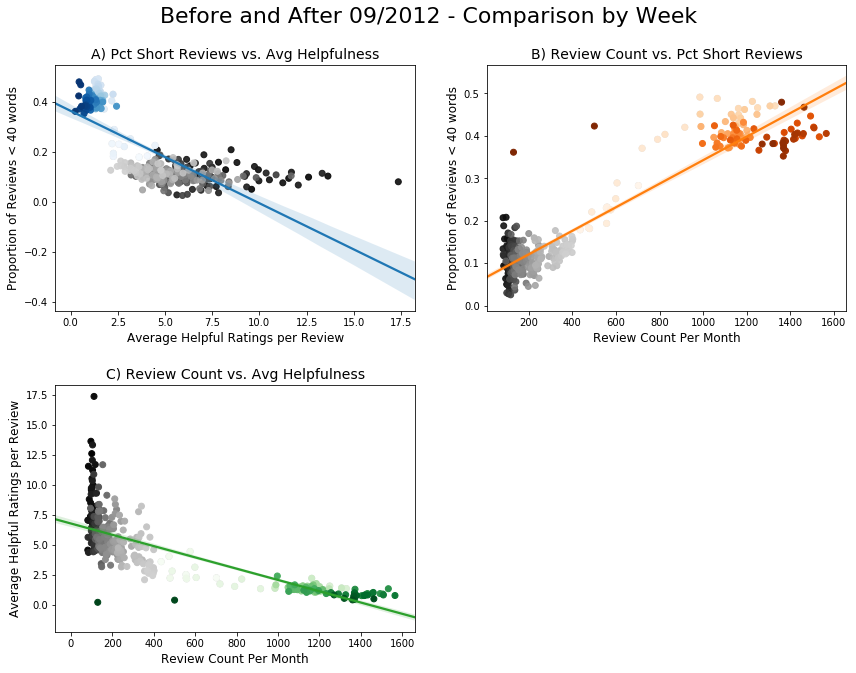

In [14]:
review_m_filter = df_compare['ReviewMonth'] >= 244

fig = plt.figure(figsize=(12, 10))
gs=gridspec.GridSpec(ncols=2, nrows=2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])

## plot average review helpful ratings against overall percentage of short reviews
g1 = ax1.scatter(x=df_compare['HelpfulRatingsAvg'], y=df_compare['ShortReviewPct'], 
            c=df_compare['ReviewMonth'], cmap="Greys_r", alpha = 0.9, label='before 09/2012')
g1_overlay = ax1.scatter(x=df_compare[review_m_filter]['HelpfulRatingsAvg'], 
                         y=df_compare[review_m_filter]['ShortReviewPct'], 
                         c=df_compare[review_m_filter]['ReviewMonth'], cmap="Blues", label='after 09/2012')
g1_linreg = sns.regplot(x='HelpfulRatingsAvg', y='ShortReviewPct', 
                 data=df_compare, ax=ax1, scatter=False)

# plot review count against percentage of short reviews
g2 = ax2.scatter(x=df_compare['ReviewCount'], y=df_compare['ShortReviewPct'], 
            c=df_compare['ReviewMonth'], cmap="Greys_r", alpha = 0.9, label='before 09/2012')
g2_overlay = ax2.scatter(x=df_compare[review_m_filter]['ReviewCount'], 
                         y=df_compare[review_m_filter]['ShortReviewPct'],
                         c=df_compare[review_m_filter]['ReviewMonth'], cmap="Oranges", label='after 09/2012')
g2_linreg = sns.regplot(x='ReviewCount', y='ShortReviewPct', data=df_compare, ax=ax2, scatter=False)


g3 = ax3.scatter(x=df_compare['ReviewCount'], y=df_compare['HelpfulRatingsAvg'], 
            c=df_compare['ReviewMonth'], cmap="Greys_r", label='before 09/2012')
g3_overlay = ax3.scatter(x=df_compare[review_m_filter]['ReviewCount'], 
                         y=df_compare[review_m_filter]['HelpfulRatingsAvg'], 
                         c=df_compare[review_m_filter]['ReviewMonth'], cmap="Greens", label='after 09/2012')
g3_linreg = sns.regplot(x='ReviewCount', y='HelpfulRatingsAvg', data=df_compare, ax=ax3, scatter=False )

st = fig.suptitle('Before and After 09/2012 - Comparison by Week', fontsize=22)
ax1.set_title('A) Pct Short Reviews vs. Avg Helpfulness')
ax2.set_title('B) Review Count vs. Pct Short Reviews')
ax3.set_title('C) Review Count vs. Avg Helpfulness')

ax1.set_xlabel('Average Helpful Ratings per Review', fontsize=12)
ax1.set_ylabel('Proportion of Reviews < 40 words', fontsize=12)
ax2.set_xlabel('Review Count Per Month', fontsize=12)
ax2.set_ylabel('Proportion of Reviews < 40 words', fontsize=12)
ax3.set_xlabel('Review Count Per Month', fontsize=12)
ax3.set_ylabel('Average Helpful Ratings per Review', fontsize=12)

ax_list = [ax1, ax2, ax3]
for a in ax_list:
    a.title.set_fontsize(14)

plt.tight_layout()
st.set_y(0.93)
fig.subplots_adjust(top=0.85, hspace=0.3, wspace=0.2)
plt.show()

In [15]:
r_a, p_a = stats.pearsonr(M_short_review_pct, M_helpful_ratings_avg)
r_b, p_b = stats.pearsonr(M_review_count, M_short_review_pct)
r_c, p_c = stats.pearsonr(M_review_count, M_helpful_ratings_avg)
print('Plot A) R-squared value: {:0.2f}, p-value: {:0.2f}'.format(r_a * r_a, p_a))
print('Plot B) R-squared value: {:0.2f}, p-value: {:0.2f}'.format(r_b * r_b, p_b))
print('Plot C) R-squared value: {:0.2f}, p-value: {:0.2f}'.format(r_c * r_c, p_c))

Plot A) R-squared value: 0.57, p-value: 0.00
Plot B) R-squared value: 0.89, p-value: 0.00
Plot C) R-squared value: 0.60, p-value: 0.00


In plot A above, the average number of helpful ratings per review fell as the percentage of reviews shorter than 40 words went up, with the greyscale cluster representing reviews written before Amazon's change in policy and blue representing those written after.

From plot B, it is evident that the number of reviews shorter than 30 words increased dramatically after the change in policy, with the greyscale cluster again representing reviews written before the policy change.

From plot C, using a similar color scheme, we can see that the average number of helpful ratings per review fell dramatically after Amazon's change in policy,

All of the plots above fall into roughly two groups, and the division between those groups can be clearly delineated between weeks before the beginning of September 2012, when Amazon implemented its new review policies, and those after.

The relationship between values in each of these plots is significant. The variance in reviews under 40 words predicts 57% of the variance in average helpful ratings per review. Review counts predict 89% of the variance in reviews under 40 words and 60% of the variance in average helpful ratings per review.

It is clear that there is a relationship between all of these factors, and that Amazon's change in policy strongly effected the nature of reviews on its site. However, since this is only one relatively small sample, I will replicate random samples of this data to ensure the results are accurate.

In [16]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates_r= np.empty(size)
    bs_replicates_p= np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates_r[i], bs_replicates_p[i] = func(bs_x, bs_y)

    return bs_replicates_r, bs_replicates_p

In [17]:
r_a, p_a = draw_bs_pairs(M_short_review_pct, M_helpful_ratings_avg, stats.pearsonr, 10000)
r_b, p_b = draw_bs_pairs(M_review_count, M_short_review_pct, stats.pearsonr, 10000)
r_c, p_c = draw_bs_pairs(M_review_count, M_helpful_ratings_avg, stats.pearsonr, 10000)
r_a2 = r_a*r_a
r_b2 = r_b*r_b
r_c2 = r_c*r_c
r_a2_perc = np.percentile(r_a2, [2.5, 97.5])
r_b2_perc = np.percentile(r_b2, [2.5, 97.5])
r_c2_perc = np.percentile(r_c2, [2.5, 97.5])
print('Plot A) The 95% confidence interview for ' + 
      'R-squared replicates is {:0.2f}, {:0.2f} '.format(r_a2_perc[0], r_a2_perc[1]))
print('Plot B) The 95% confidence interview for ' + 
      'R-squared replicates is {:0.2f}, {:0.2f}'.format(r_b2_perc[0], r_b2_perc[1]))
print('Plot C) The 95% confidence interview for ' +
      'R-squared replicates is {:0.2f}, {:0.2f}'.format(r_c2_perc[0], r_c2_perc[1]))

Plot A) The 95% confidence interview for R-squared replicates is 0.51, 0.65 
Plot B) The 95% confidence interview for R-squared replicates is 0.86, 0.91
Plot C) The 95% confidence interview for R-squared replicates is 0.54, 0.67


Replicating the Amazon review data 10,000 times and calculating the R-squared and p-values for these replicates shows that the values obtained are well within a 95% confidence interval calculated through replication.

It can be definitively stated that there is a relationship between these three metrics, and that the changes in these three were caused by Amazon's change in policy.

But this still leaves the question of whether or not Amazon's changes in policy is better for consumers open, regardless of whether or not people are hitting the "helpful" button on reviews as often. One way to measure this is to look at how much information is contained within reviews before Amazon's policy change compared to afterwards. This can be done by performing an unsupervised LDA topic modeling on all the reviews overall, the reviews before, and the reviews after, then comparing this results. The results will be comprised of 2 metrics, as well as a plot which indicates the distribution of topics discovered by the LDA model. If the topics in the plot are closely clustered together, this would indicate that they have a high degree of similarity, and therefore convey less unique information than topics that are spread futher apart.

The two metrics provided by the LDA model are perplexity and coherence. Lower perplexity scores indicate that that the LDA model predicts a sample better than higher perplexity scores. In this instance the coherence score is the most useful metric, with higher coherence scores being better. A higher coherence score indicates that the set of words in each topic are related and meaningful, for instance the set {sport, ball, team, score} would have a high degree of coherence due to the words being both specific and related by topic, while {want, go, know, be} would have a low degree of coherence due to being general and not related by topic.

The number of topics to be predicted is set before hand. In this instance, a variety of numbers of topics were tested, but for speed of results and clarity, 15 topics ended up being a good number with results that are consistent with other numbers of topics tested.

In [18]:

def strip_punct(in_str):
    # Remove punctuation from string.
    punct_filt = string.punctuation
    trans = str.maketrans('','', punct_filt)
    return in_str.translate(trans)

def make_processed_sentence(in_str):
    # Remove punctuation and split string into list of words  
    no_punct_lc = strip_punct(str(in_str))
    word_list = no_punct_lc.split(' ')
    return word_list

def remove_stopwords(str_list):
    # Remove trivial words from list of words.
    stopwords_list = stopwords.words('english')
    no_stopwords = []
    for sentence in str_list:
        no_stopwords.append([word for word in sentence if word not in stopwords_list])
    return no_stopwords    
    
    
def build_bigram_model(proc_text_list, m_c, thresh):
    bigram = gensim.models.Phrases(proc_text_list, min_count=m_c, threshold=thresh) 
    return bigram 

def apply_bigram_model(bigram):
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def make_bigrams(review_list, bigram_mod):
    bigrams = [bigram_mod[review] for review in review_list]
    return bigrams

def lemmatization(review_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], disallowed_postags=['PROPN']):
    """https://spacy.io/api/annotation"""
    reviews_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for review in review_list:
        rev = nlp(" ".join(review)) 
        reviews_out.append([token.lemma_ for token in rev 
                            if token.pos_ in allowed_postags 
                            and token.pos_ not in disallowed_postags])
    return reviews_out

def build_lda_model(text_df, text_column):
    proc_text_list = []
    for review in text_df['reviewText']:
        proc_text_list.append(make_processed_sentence(review))

    # Remove Stop Words
    review_words_nostops = remove_stopwords(proc_text_list)

    # Form Bigrams
    bigram=build_bigram_model(proc_text_list, 5, 25)
    bigram_mod=apply_bigram_model(bigram)
    review_words_bigrams = make_bigrams(review_words_nostops, bigram_mod)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en

    # Do lemmatization keeping only noun, adj, vb, adv
    reviews_lemmatized = lemmatization(review_words_bigrams, 
                                       allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], 
                                       disallowed_postags=['PROPN'])

    # Create Dictionary
    id2word = corpora.Dictionary(reviews_lemmatized)
    id2word.filter_extremes(no_below=30, no_above=0.20)

    # Create Corpus
    review_texts = reviews_lemmatized

    # Term Document Frequency
    texts_bow = [id2word.doc2bow(text) for text in review_texts]


    lda_model = gensim.models.ldamodel.LdaModel(corpus=texts_bow,
                                               id2word=id2word,
                                               num_topics=15, 
                                               random_state=102,
                                               update_every=1,
                                               chunksize=1000,
                                               passes=15,
                                               alpha='auto',
                                               per_word_topics=True)

    # Compute Perplexity. Lower scores are better.
    print('\nPerplexity: ', lda_model.log_perplexity(texts_bow))  

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_lemmatized, 
                                         dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, texts_bow, id2word)
    return lda_model, vis, coherence_lda




In [19]:
reviews_before_filter = reviews_df['reviewTime'] < '2012-09-01'
reviews_after_filter = reviews_df['reviewTime'] >= '2012-09-01'

def equalize_selections(a, b):
    """
    Input: two boolean arrays
    Output: two boolean arrays with equal numbers of "true" values    
    """
    a_ti = [i for i, a in enumerate(a) if a == True]
    b_ti = [i for i, b in enumerate(b) if b == True]
    if len(a_ti) > len(b_ti):
            num=len(a_ti)-len(b_ti)
            rnd_idx = random.sample(range(0, len(a_ti)), num)
            for i in rnd_idx:
                a[i] = False
            
    elif len(b_ti) > len(a_ti):
            num=np.sum(b)-np.sum(a)
            rnd_idx = random.sample(range(0, len(b_ti)), num)
            for i in rnd_idx:
                b[b_ti[i]] = False
    else:
        return a,b
    
    return a,b


In [20]:
reviews_before_filt_eq, reviews_after_filt_eq = equalize_selections(reviews_before_filter, reviews_after_filter)


In [21]:
lda_model_all, vis_all, coherence_all = build_lda_model(reviews_df, 'reviewsText')


Perplexity:  -7.79812496773

Coherence Score:  0.417174912863


We can see the perplexity and coherence score of all of reviews in total above, which provides a valuable reference point when looking at reviews before and after the policy change.

In [22]:
lda_model_before, vis_before, coherence_before = build_lda_model(
    reviews_df[reviews_before_filt_eq], 'reviewText')


Perplexity:  -7.89364854513

Coherence Score:  0.46122500792


Above are the perplexity and coherence scores for reviews written before Amazon's change in policy. It is clear that perplexity score is lower than that of all of the reviews considered as a whole, and that the coherence is more than 10% higher.

In [23]:
lda_model_after, vis_after, coherence_after = build_lda_model(
    reviews_df[reviews_after_filt_eq], 'reviewText')


Perplexity:  -7.34654096094

Coherence Score:  0.357382024741


Lastly, we have the scores for reviews written after the policy change. The perplexity score for these reviews is significantly higher than that of either of the other sets of reviews, indicating that it was not as possible to predict topics for a sample from these reviews as it was from either of the other sets. Moreover, the coherence score for the reviews written after the policy change was 12% lower than that of all reviews together, and was over 25% lower than that of reviews written before the change.

In [24]:
vis_before

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.220543 -0.112955       1        1  24.137051
10     0.204378  0.022433       2        1  14.406425
11     0.149943 -0.139285       3        1  13.767030
8      0.093989 -0.050248       4        1   9.473891
5      0.053221 -0.289162       5        1   9.202587
12     0.157856  0.149107       6        1   6.170417
0      0.081477 -0.004242       7        1   5.969699
7     -0.001827  0.222128       8        1   3.736330
3      0.110188  0.251903       9        1   3.702894
9     -0.133861  0.038323      10        1   2.234421
14    -0.164547 -0.043567      11        1   2.056958
2     -0.219140 -0.040482      12        1   1.539209
13    -0.160386 -0.075967      13        1   1.288844
1     -0.169550  0.070061      14        1   1.181107
4     -0.222284  0.001954      15        1   1.133139, topic_info=     Category          Freq                  Term         Total  loglift  \
term                                                                       
147   Default  15583.000000                   use  15583.000000  30.0000   
1430  Default   8753.000000                 child   8753.000000  29.0000   
1485  Default  14192.000000                series  14192.000000  28.0000   
51    Default  13537.000000                 novel  13537.000000  27.0000   
341   Default  11915.000000                 enjoy  11915.000000  26.0000   
400   Default  12666.000000                   man  12666.000000  25.0000   
730   Default  11343.000000                  live  11343.000000  24.0000   
143   Default  18438.000000                 thing  18438.000000  23.0000   
135   Default  18304.000000                   say  18304.000000  22.0000   
1503  Default   9896.000000                family   9896.000000  21.0000   
222   Default  15660.000000                reader  15660.000000  20.0000   
200   Default   9485.000000                 woman   9485.000000  19.0000   
134   Default  19861.000000                     s  19861.000000  18.0000   
92    Default  18040.000000                  feel  18040.000000  17.0000   
9     Default   9875.000000                  page   9875.000000  16.0000   
329   Default   6887.000000               chapter   6887.000000  15.0000   
561   Default   4881.000000                  girl   4881.000000  14.0000   
5     Default  14235.000000                little  14235.000000  13.0000   
932   Default   4698.000000                  play   4698.000000  12.0000   
122   Default  18267.000000                people  18267.000000  11.0000   
214   Default  12752.000000                  have  12752.000000  10.0000   
451   Default   6879.000000               include   6879.000000   9.0000   
108   Default  12278.000000                   lot  12278.000000   8.0000   
23    Default  12655.000000                  need  12655.000000   7.0000   
157   Default  12258.000000                  like  12258.000000   6.0000   
906   Default   5819.000000                 cover   5819.000000   5.0000   
286   Default   6879.000000                  plot   6879.000000   4.0000   
1894  Default   5268.000000               mystery   5268.000000   3.0000   
150   Default   5004.000000                 young   5004.000000   2.0000   
479   Default  12034.000000                   try  12034.000000   1.0000   
...       ...           ...                   ...           ...      ...   
2246  Topic15    733.945618                 alien    734.974060   4.4788   
553   Topic15    700.882629                  crew    701.911072   4.4787   
4126  Topic15    519.065430                 plane    520.093872   4.4782   
1588  Topic15    436.037018                   sea    437.065460   4.4778   
1900  Topic15    409.902954                 pilot    410.931396   4.4777   
1590  Topic15    398.695709                  sink    399.724152   4.4776   
2291  Topic15    380.083191                pirate    381.111633   4.4775   

In [25]:
vis_after

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.269599 -0.030216       1        1  36.238762
1      0.261436 -0.066315       2        1  15.846257
4      0.182656  0.116596       3        1  11.144993
11     0.087905  0.338907       4        1   8.279268
3      0.141820 -0.179198       5        1   7.616404
13     0.090513  0.048680       6        1   4.449499
10    -0.096906  0.015086       7        1   4.197527
7      0.001051 -0.261675       8        1   3.292513
14    -0.139679  0.057800       9        1   1.788236
8     -0.136105  0.015937      10        1   1.529228
12    -0.130276  0.018069      11        1   1.365372
0     -0.123546 -0.023731      12        1   1.340397
2     -0.135923 -0.008244      13        1   1.012768
9     -0.136129 -0.015401      14        1   0.985982
5     -0.136416 -0.026295      15        1   0.912792, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
10    Default  16651.000000           great  16651.000000  30.0000  30.0000
350   Default  16543.000000          series  16543.000000  29.0000  29.0000
230   Default  10802.000000            keep  10802.000000  28.0000  28.0000
99    Default   7918.000000             man   7918.000000  27.0000  27.0000
21    Default  17195.000000          author  17195.000000  26.0000  26.0000
27    Default  12275.000000           enjoy  12275.000000  25.0000  25.0000
52    Default  12761.000000            life  12761.000000  24.0000  24.0000
558   Default   5434.000000           woman   5434.000000  23.0000  23.0000
647   Default   6727.000000             use   6727.000000  22.0000  22.0000
34    Default  19749.000000          really  19749.000000  21.0000  21.0000
132   Default  18073.000000              go  18073.000000  20.0000  20.0000
2024  Default   5673.000000         romance   5673.000000  19.0000  19.0000
38    Default  17918.000000            want  17918.000000  18.0000  18.0000
348   Default   7040.000000            next   7040.000000  17.0000  17.0000
39    Default  16990.000000              be  16990.000000  16.0000  16.0000
147   Default   5373.000000           novel   5373.000000  15.0000  15.0000
246   Default   7109.000000          reader   7109.000000  14.0000  14.0000
385   Default   4749.000000             fun   4749.000000  13.0000  13.0000
511   Default   4715.000000            plot   4715.000000  12.0000  12.0000
484   Default   5018.000000            turn   5018.000000  11.0000  11.0000
375   Default  14657.000000           think  14657.000000  10.0000  10.0000
26    Default  13391.000000             end  13391.000000   9.0000   9.0000
936   Default   3111.000000          recipe   3111.000000   8.0000   8.0000
31    Default  17024.000000            know  17024.000000   7.0000   7.0000
149   Default   7164.000000          people   7164.000000   6.0000   6.0000
30    Default  12751.000000           first  12751.000000   5.0000   5.0000
118   Default  11698.000000          -PRON-  11698.000000   4.0000   4.0000
62    Default   4919.000000       recommend   4919.000000   3.0000   3.0000
869   Default   7471.000000            help   7471.000000   2.0000   2.0000
144   Default  12058.000000            much  12058.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
940   Topic15    684.063782  absolutely_lov    685.102173   4.6949  -3.4749
4951  Topic15    676.943542          zombie    677.981934   4.6949  -3.4854
3097  Topic15    573.558167       delicious    574.596558   4.6946  -3.6511
3542  Topic15    549.906372           water    550.944763   4.6945  -3.6932
3799  Topic15    408.687897      heartbreak    409.726288   4.6939  -3.9900
1300  Topic15    377.908813          endure    378.947205   4.6937  -4.0683
4239  Topic15    349.216705           storm    350.255096   4.6934  -4.1473

The conclusions drawn from analyzing the coherence and perplexity scores of the topic models can be seen more tangibly in the plots of their topics above. The topics in the top-most plot are for the reviews written before Amazon's policy change. The topics in this plot are fairly spread out, indicating well defined topics, and looking at the words contained in the topics, they tend to contain words that are closely related. While the largest topics on the map contain a larger number of less-related words, the topics gain a lot more definition after the first three.

The topics in the lower plot are for reviews written after Amazon's policy change. They are clustered much more closely together, which indicates that the topics are not well defined and may overlap significantly. The words in the largest topics tend to be less related than those in the topics before the policy change, and this extends out through the fifth most common topic. Much more overlap is apparent in this model even for the higher-numbered, smaller topics.

It is safe to conclude from all of the above that Amazon's reviews are both less helpful and less informative than they were before the policy change in 2012. It is evident that, if Amazon's goal was to maximize the helpfulness of reviews on their site, their policy change was a poor decision. Barring people from writing reviews who love writing enough to dedicate their lives to it seems counter-intuitive, and its negative effects can be objectively observed. Instead of the lengthier, more helpful reviews which predominated Amazon book reviews until September of 2012, consumers are now met with very short reviews which, apparently, very few of them find helpful.

Anyone who purchases on Amazon, whether for personal or professional reasons, would benefit from keeping the effects of this policy change in mind an adopt the following strategies as a result:
<ul>
    <li>More reviews is not necessarily better, even if they tend to be positive. Maintain a healthy suspicion of short reviews.</li>
    <li>Seek out longer reviews, they may take longer to read, but they will almost always contain more information.</li>
    <li>See out reviews that are helpful, and use the "helpful" button to rate reviews and guide others to those that are worthwhile.</li>
</ul>